### 추세 지속 일수 분석

In [1]:
%matplotlib inline
import sys, os
sys.path.append('../..')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict
from itertools import groupby
import h5py
from IPython.display import clear_output
import math

In [2]:
path = os.path.join('..','..','data','trend index','trend_index.hdf')
file = h5py.File(path, mode='r')

In [3]:
def mean_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- NumPy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

In [4]:
def calc(trend, index):
    trend = np.concatenate(trend)
    trend[trend < index] = 0
    trend[trend >= index] = 1
    trend = trend.astype('int')
    
    # 연속된 값사이의 차가 1이거나 (0에서 1로 바뀜)
    # -1 (1에서 0으로 바뀜) 인 곳의 인덱스를 기준으로 split 함
    split_by_consecutive = [np.array(list(v)).cumsum() for k,v in groupby(trend)]
    trendidx = np.concatenate(split_by_consecutive)
    counter = Counter(sorted(trendidx))
    
    days = []
    cnt = []
    for k,v in counter.items():
        days.append(k)
        cnt.append(v)
    # 조건부 확률 P(내일도 지속| 오늘 지속)
    days = np.array(days[1:])
    cnt = np.array(cnt[1:])
    cond_prob = [ sum(cnt[x+1:]) / sum(cnt[x:]) for x in range(len(cnt)-1)]
    
    return (days, cnt, cond_prob)

최장 지속일: up: 162일, side:120일, down: 144일
평균 지속일: up: 19.9일, side: 14.3일, down: 17.3일
표준편차: up: 20.2일, side: 13.4일, down: 17.6일


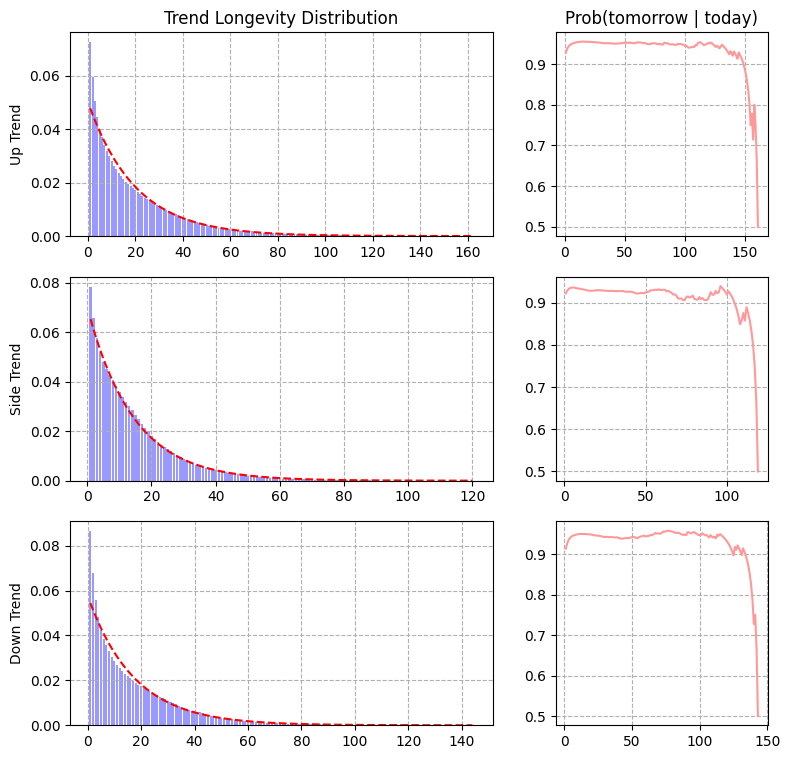

In [5]:
period=50
# 추세기준값 설정
index = 0.7
uptrend = []
sidetrend = []
downtrend = []
for ti in file.values():
    uptrend.append(ti[f'trend{period}'][:,3])
    sidetrend.append(ti[f'trend{period}'][:,2])
    downtrend.append(ti[f'trend{period}'][:,1])

updays, upcnt, upprob = calc(uptrend, index)
sidedays, sidecnt, sideprob = calc(sidetrend, index)
downdays, downcnt, downprob = calc(downtrend, index)

upmean, upstd = mean_and_std(updays, upcnt)
sidemean, sidestd = mean_and_std(sidedays, sidecnt)
downmean, downstd = mean_and_std(downdays, downcnt)

print(f"최장 지속일: up: {updays[-1]}일, side:{sidedays[-1]}일, down: {downdays[-1]}일")
print(f"평균 지속일: up: {round(upmean,1)}일, side: {round(sidemean,1)}일, down: {round(downmean,1)}일")
print(f"표준편차: up: {round(upstd, 1)}일, side: {round(sidestd,1)}일, down: {round(downstd,1)}일")

# 그래프
f, (ax) = plt.subplots(3,2, figsize=(9,9), gridspec_kw={'width_ratios':[2, 1]} )

ax[0][0].bar(updays, upcnt/upcnt.sum(), color='#9999ff')
ax[0][1].plot(updays[:-1], upprob, color='#ff9999')
ax[1][0].bar(sidedays, sidecnt/sidecnt.sum(), color='#9999ff')
ax[1][1].plot(sidedays[:-1], sideprob, color='#ff9999')
ax[2][0].bar(downdays, downcnt/downcnt.sum(), color='#9999ff')
ax[2][1].plot(downdays[:-1], downprob, color='#ff9999')

#exponential distribution
lamb = 1/upmean
expup = lamb * np.exp(-lamb*(updays))
lamb = 1/sidemean
expside = lamb * np.exp(-lamb*(sidedays))
lamb = 1/downmean
expdown = lamb * np.exp(-lamb*(downdays))

ax[0][0].plot(updays, expup, linestyle='--', color='red')
ax[1][0].plot(sidedays, expside, linestyle='--', color='red')
ax[2][0].plot(downdays, expdown, linestyle='--', color='red')

for axe in f.get_axes():
    axe.grid(linestyle='--')
ax[0][0].set_title("Trend Longevity Distribution")
ax[0][1].set_title("Prob(tomorrow | today)")
ax[0][0].set_ylabel('Up Trend')
ax[1][0].set_ylabel('Side Trend')
ax[2][0].set_ylabel('Down Trend')
plt.show()

In [6]:
p = np.percentile(upprob, [25,50,75])

In [7]:
p

array([0.94262295, 0.94970178, 0.95191524])

In [212]:
p[0]-(p[2]-p[0])*1.5

0.7431482757561683

In [206]:
np.percentile?

In [140]:
def lastlong(period, threshold):
    uptrend = []
    sidetrend = []
    downtrend = []
    for ti in file.values():
        uptrend.append(ti[f'trend{period}'][:,3])
        sidetrend.append(ti[f'trend{period}'][:,2])
        downtrend.append(ti[f'trend{period}'][:,1])

    updays, upcnt, upprob = calc(uptrend, threshold)
    sidedays, sidecnt, sideprob = calc(sidetrend, threshold)
    downdays, downcnt, downprob = calc(downtrend, threshold)
    
    upaverage, upstd = avg_and_std(updays, upcnt)
    sideaverage, sidestd = avg_and_std(sidedays, sidecnt)
    downaverage, downstd = avg_and_std(downdays, downcnt)

    return {
        'up': [updays[-1], upaverage, upstd ],
        'side': [sidedays[-1], sideaverage, sidestd],
        'down': [downdays[-1], downaverage, downstd]
    }

In [141]:
period = 50
data = {'up':{'max':[], 'avg':[], 'std':[]},
        'side':{'max':[], 'avg':[], 'std':[]},
        'down':{'max':[], 'avg':[], 'std':[]},
        'th': [] }
for th in np.arange(0.01, 1, 0.01):
    print(f'Threshold: {th}')
    data['th'].append(th)
    ret = lastlong(period, th)
    data['up']['max'].append(ret['up'][0])
    data['up']['avg'].append(ret['up'][1])
    data['up']['std'].append(ret['up'][2])
    data['side']['max'].append(ret['side'][0])
    data['side']['avg'].append(ret['side'][1])
    data['side']['std'].append(ret['side'][2])
    data['down']['max'].append(ret['down'][0])
    data['down']['avg'].append(ret['down'][1])
    data['down']['std'].append(ret['down'][2])
    clear_output(wait=True)
    

Threshold: 0.99


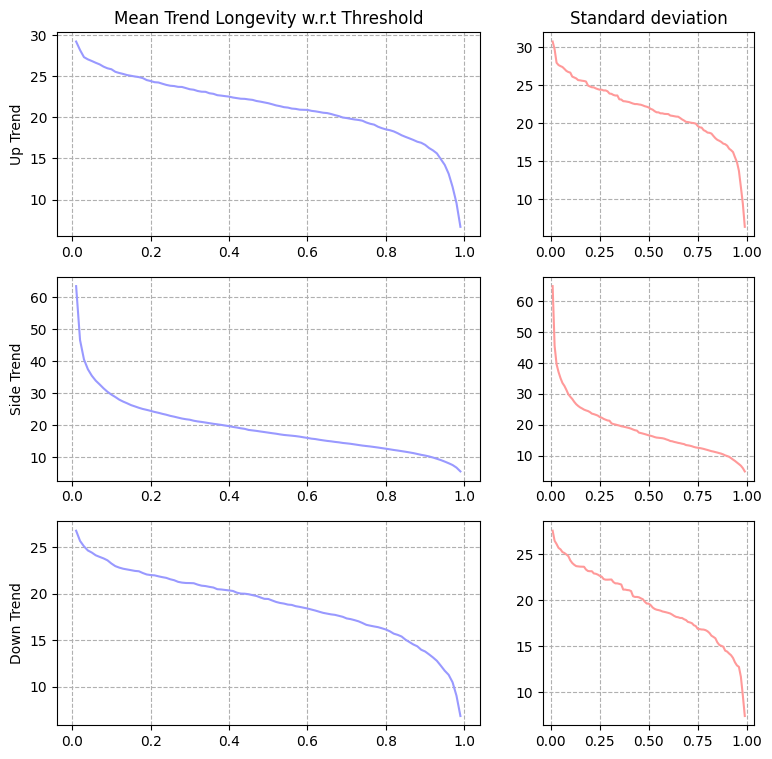

In [199]:
# 그래프
f, (ax) = plt.subplots(3,2, figsize=(9,9), gridspec_kw={'width_ratios':[2, 1]} )

ax[0][0].plot(data['th'], data['up']['avg'], color='#9999ff')
ax[0][1].plot(data['th'], data['up']['std'], color='#ff9999')
ax[1][0].plot(data['th'], data['side']['avg'], color='#9999ff')
ax[1][1].plot(data['th'], data['side']['std'], color='#ff9999')
ax[2][0].plot(data['th'], data['down']['avg'], color='#9999ff')
ax[2][1].plot(data['th'], data['down']['std'], color='#ff9999')
for axe in f.get_axes():
    axe.grid(linestyle='--')
ax[0][0].set_title("Mean Trend Longevity w.r.t Threshold")
ax[0][1].set_title("Standard deviation")
ax[0][0].set_ylabel('Up Trend')
ax[1][0].set_ylabel('Side Trend')
ax[2][0].set_ylabel('Down Trend')
plt.show()